In [1]:
!pip install -U --upgrade tensorflow

Load Dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

deepfake-and-real-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/deepfake-and-real-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from keras import layers
#from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import numpy as np
import cv2
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint, CSVLogger
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy as logloss
from tensorflow.keras.metrics import categorical_accuracy
import pandas as pd
import os
from PIL import Image
import scipy
from sklearn import metrics
from sklearn.model_selection import train_test_split
import json

In [ ]:
train_dir = '/content/Dataset/Train'
validation_dir = '/content/Dataset/Validation'
test_dir = '/content/Dataset/Test'

Load A Random Image

target folder /content/Dataset/Train/Real
Image shape: (256, 256, 3)


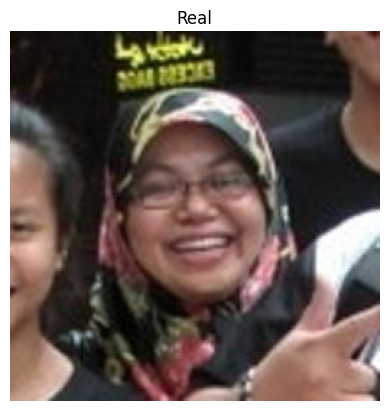

In [ ]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  target_folder = target_dir + "/" + target_class
  print(f"target folder {target_folder}")
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

# View random image
img = view_random_image(target_dir=train_dir,
                        target_class="Real")

Image Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)

TinyVGG model

In [ ]:
# End to End TinyVGG Model

tf.random.set_seed(42)

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=12, #5, 8
                        steps_per_epoch=128, # 44, 99, 128, 4k XD
                        validation_data=valid_data,
                        validation_steps=128)

Found 140002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
Epoch 1/12
128/128 [==============================] - 63s 451ms/step - loss: 0.6926 - accuracy: 0.5400 - val_loss: 0.6747 - val_accuracy: 0.5654
Epoch 2/12
128/128 [==============================] - 61s 481ms/step - loss: 0.6723 - accuracy: 0.5889 - val_loss: 0.6579 - val_accuracy: 0.6067
Epoch 3/12
128/128 [==============================] - 62s 482ms/step - loss: 0.6612 - accuracy: 0.5999 - val_loss: 0.6702 - val_accuracy: 0.5977
Epoch 4/12
128/128 [==============================] - 61s 479ms/step - loss: 0.6534 - accuracy: 0.6189 - val_loss: 0.6439 - val_accuracy: 0.6423
Epoch 5/12
128/128 [==============================] - 61s 474ms/step - loss: 0.6475 - accuracy: 0.6250 - val_loss: 0.6609 - val_accuracy: 0.6313
Epoch 6/12
128/128 [==============================] - 60s 468ms/step - loss: 0.6507 - accuracy: 0.6262 - val_loss: 0.6551 - val_accuracy: 0.6077
Epoch 7/12
128/128 [=======================

Accuracy: 0.6609

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

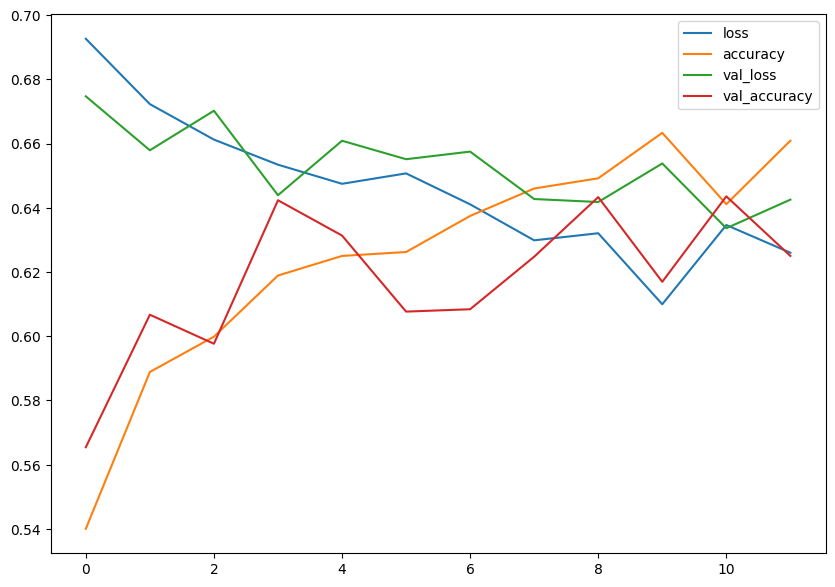

In [ ]:
pd.DataFrame(history_1.history).plot(figsize=(10, 7));

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

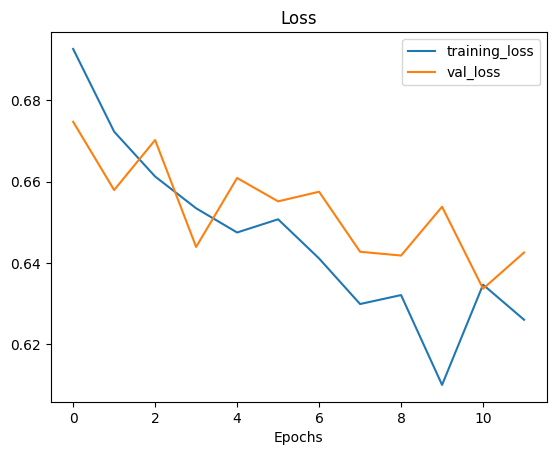

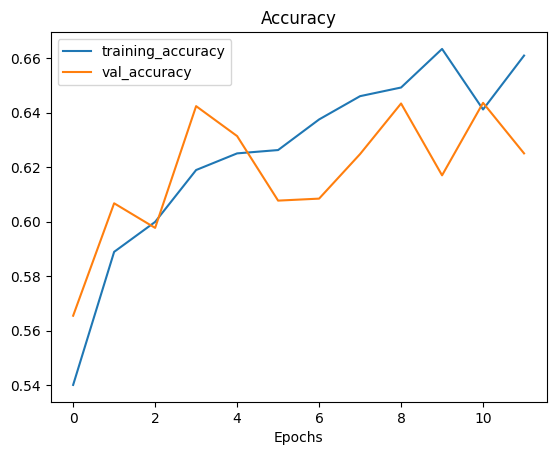

In [ ]:
plot_loss_curves(history_1)

1- Similar to TinyVGG but with a MaxPooling layer after every Conv2D layer.
2- Potentially reducing the number of parameters and computational load, and hence reducing the risk of overfitting.

In [ ]:
# model_2 with a MaxPool2D layer after every Conv2D layer

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

tf.random.set_seed(42)

model_2 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=64,
                        validation_data=valid_data,
                        validation_steps=64)

Epoch 1/5
64/64 [==============================] - 32s 466ms/step - loss: 0.6939 - accuracy: 0.5054 - val_loss: 0.6920 - val_accuracy: 0.5381
Epoch 2/5
64/64 [==============================] - 29s 447ms/step - loss: 0.6900 - accuracy: 0.5327 - val_loss: 0.6788 - val_accuracy: 0.6104
Epoch 3/5
64/64 [==============================] - 29s 448ms/step - loss: 0.6839 - accuracy: 0.5708 - val_loss: 0.6561 - val_accuracy: 0.6323
Epoch 4/5
64/64 [==============================] - 30s 472ms/step - loss: 0.6662 - accuracy: 0.5854 - val_loss: 0.6631 - val_accuracy: 0.5908
Epoch 5/5
64/64 [==============================] - 30s 462ms/step - loss: 0.6708 - accuracy: 0.5938 - val_loss: 0.6494 - val_accuracy: 0.6157


Accuracy: 0.5938

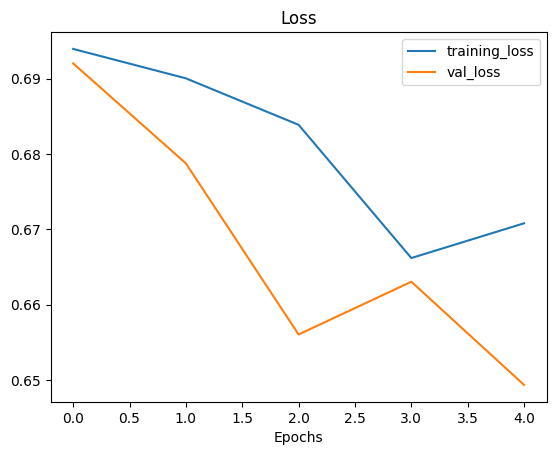

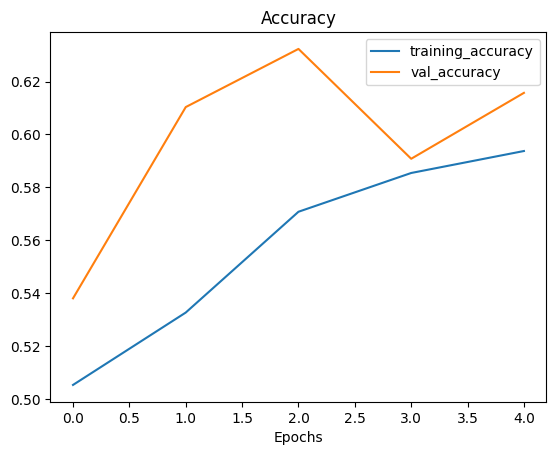

In [ ]:
plot_loss_curves(history_2)

 Try DataAugmentation during image preprocessing.

Read an image file, preprocess it, and return the preprocessed image as a tensor

In [ ]:
def load_and_prep_image(filename, img_shape=224):
  # Read in target file (an image)
  print(filename)
  img = tf.io.read_file(filename)

  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  return img

In [ ]:
train_img_path_1 = f"{test_dir}/Real/real_4.jpg"
train_img_path_2 = f"{test_dir}/Fake/fake_12.jpg"
train_img_real_1 = load_and_prep_image(train_img_path_1)
train_img_real_2 = load_and_prep_image(train_img_path_2)
train_img_real_1 = tf.expand_dims(train_img_real_1, axis=0)
train_img_real_2 = tf.expand_dims(train_img_real_2, axis=0)

/content/Dataset/Test/Real/real_4.jpg
/content/Dataset/Test/Fake/fake_12.jpg


In [ ]:
pred_1 = model_2.predict(train_img_real_1)
pred_2 = model_2.predict(train_img_real_2)
print(pred_1)
print(pred_2)

1/1 [==============================] - 0s 18ms/step
[[0.6407768]]
[[0.47725418]]


CNN Models with ResNet50

In [ ]:
input_shape=(224,224,3)
batch_size=64


def build_model():
    densenet = ResNet50(
                        weights='imagenet',
                        include_top=False,
                        input_shape=input_shape
                        )
    model = Sequential([densenet,
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(64,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dropout(0.5),
                        layers.Dense(1, activation='sigmoid')
                        ])
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                 )
    return model


model_resnet = build_model()
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 64)                131136    
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
tf.random.set_seed(42)
history = model_resnet.fit(train_data,
    epochs = 8,
    steps_per_epoch = 256,
    validation_data =valid_data,
    validation_steps = 256
)

Epoch 1/8
256/256 [==============================] - 227s 730ms/step - loss: 0.6662 - accuracy: 0.6838 - val_loss: 0.7032 - val_accuracy: 0.4996
Epoch 2/8
256/256 [==============================] - 164s 640ms/step - loss: 0.4883 - accuracy: 0.7891 - val_loss: 2.2135 - val_accuracy: 0.4836
Epoch 3/8
256/256 [==============================] - 177s 693ms/step - loss: 0.4195 - accuracy: 0.8301 - val_loss: 1.7323 - val_accuracy: 0.5106
Epoch 4/8
256/256 [==============================] - 170s 664ms/step - loss: 0.3144 - accuracy: 0.8699 - val_loss: 0.6407 - val_accuracy: 0.7411
Epoch 5/8
256/256 [==============================] - 196s 765ms/step - loss: 0.2673 - accuracy: 0.8909 - val_loss: 0.7016 - val_accuracy: 0.7274
Epoch 6/8
256/256 [==============================] - 193s 752ms/step - loss: 0.2513 - accuracy: 0.8965 - val_loss: 0.6447 - val_accuracy: 0.6913
Epoch 7/8
256/256 [==============================] - 166s 646ms/step - loss: 0.2366 - accuracy: 0.9033 - val_loss: 0.5178 - val_ac

Accuracy: 0.9191

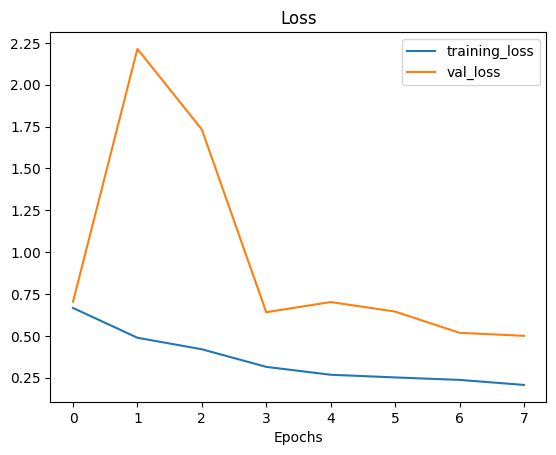

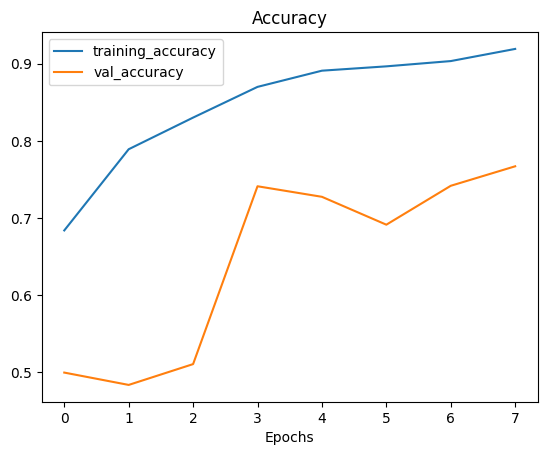

In [ ]:
plot_loss_curves(history)

In [ ]:
def build_model_2():
    densenet = ResNet50(
                        weights='imagenet',
                        include_top=False,
                        input_shape=input_shape
                        )
    model = Sequential([densenet,
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(128,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(64,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(32,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dropout(0.5),
                        layers.Dense(1, activation='sigmoid')
                        ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                 )
    return model


model_resnet_2 = build_model_2()
model_resnet_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Bat  (None, 64)               

In [ ]:
tf.random.set_seed(42)
history_resnet_2 = model_resnet_2.fit(train_data,
    epochs = 7,
    steps_per_epoch = 256,
    validation_data =valid_data,
    validation_steps = 256
)

Epoch 1/7
256/256 [==============================] - 199s 653ms/step - loss: 0.3979 - accuracy: 0.8225 - val_loss: 0.7105 - val_accuracy: 0.5078
Epoch 2/7
256/256 [==============================] - 164s 642ms/step - loss: 0.2073 - accuracy: 0.9248 - val_loss: 0.9990 - val_accuracy: 0.4943
Epoch 3/7
256/256 [==============================] - 179s 700ms/step - loss: 0.1777 - accuracy: 0.9352 - val_loss: 0.6166 - val_accuracy: 0.6914
Epoch 4/7
256/256 [==============================] - 180s 701ms/step - loss: 0.1552 - accuracy: 0.9443 - val_loss: 0.5663 - val_accuracy: 0.7959
Epoch 5/7
256/256 [==============================] - 166s 648ms/step - loss: 0.1524 - accuracy: 0.9471 - val_loss: 0.4095 - val_accuracy: 0.8342
Epoch 6/7
256/256 [==============================] - 164s 639ms/step - loss: 0.1280 - accuracy: 0.9552 - val_loss: 0.5384 - val_accuracy: 0.7926
Epoch 7/7
256/256 [==============================] - 177s 691ms/step - loss: 0.1300 - accuracy: 0.9540 - val_loss: 0.8523 - val_ac

Accuracy: 0.9540

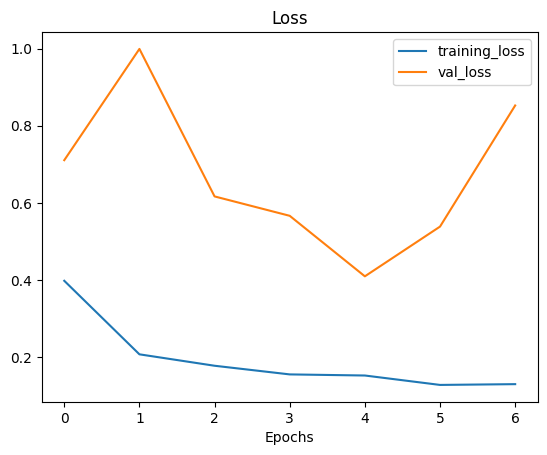

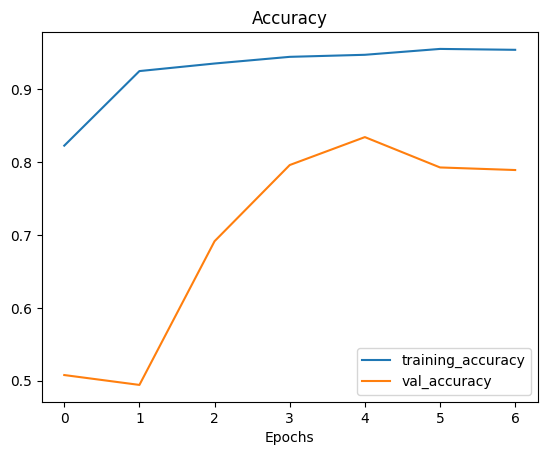

In [ ]:
plot_loss_curves(history_resnet_2)

InceptionNet

In [ ]:
from keras.applications.inception_v3 import InceptionV3

input_shape=(224,224,3)
batch_size=64

def build_model_inception():
    densenet = InceptionV3(
                        weights='imagenet',
                        include_top=False,
                        input_shape=input_shape,
                        )
    model = Sequential([densenet,
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(512,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(256,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(128,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(64,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dropout(0.5),
                        layers.Dense(1, activation='sigmoid')
                        ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                 )
    return model

model_icv3 = build_model_inception()
model_icv3.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_98 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                       

In [ ]:
tf.random.set_seed(42)
history_icv3 = model_icv3.fit(train_data,
    epochs = 8,
    steps_per_epoch = 512,
    validation_data =valid_data,
    validation_steps = 512
)

Epoch 1/8
512/512 [==============================] - ETA: 0s - loss: 0.4240 - accuracy: 0.8132

512/512 [==============================] - 337s 578ms/step - loss: 0.4240 - accuracy: 0.8132 - val_loss: 0.5293 - val_accuracy: 0.7773
Epoch 2/8
512/512 [==============================] - 270s 527ms/step - loss: 0.1924 - accuracy: 0.9265
Epoch 3/8
512/512 [==============================] - 258s 502ms/step - loss: 0.1625 - accuracy: 0.9379
Epoch 4/8
512/512 [==============================] - 250s 487ms/step - loss: 0.1360 - accuracy: 0.9492
Epoch 5/8
512/512 [==============================] - 264s 516ms/step - loss: 0.1238 - accuracy: 0.9542
Epoch 6/8
512/512 [==============================] - 258s 502ms/step - loss: 0.1150 - accuracy: 0.9581
Epoch 7/8
512/512 [==============================] - 250s 489ms/step - loss: 0.0969 - accuracy: 0.9653
Epoch 8/8
512/512 [==============================] - 248s 485ms/step - loss: 0.0989 - accuracy: 0.9655


Accuracy: 0.9655

##Code for Prediction (Classifier)

In [ ]:
import tensorflow as tf

def predict_image(model, img_path):

    # Load and preprocess the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size=(224, 224))  # Resize to model input shape
    img = img / 255.0  # Normalize pixel values

    # Expand dimensions to match model input shape
    img = tf.expand_dims(img, axis=0)

    # Make prediction
    prediction = model.predict(img)

    # Convert prediction probabilities to binary prediction
    binary_prediction = 1 if prediction > 0.5 else 0

    return binary_prediction


trained_model = model_icv3

img_path = '/content/Dataset/Train/Fake/fake_10014.jpg'


prediction = predict_image(trained_model, img_path)
print("Prediction:", prediction)


1/1 [==============================] - 9s 9s/step

Prediction: 0

In [ ]:
import tensorflow as tf

def predict_image(model, img_path):

    # Load and preprocess the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size=(224, 224))  # Resize to model input shape
    img = img / 255.0  # Normalize pixel values

    # Expand dimensions to match model input shape
    img = tf.expand_dims(img, axis=0)

    # Make prediction
    prediction = model.predict(img)

    # Convert prediction probabilities to binary prediction
    binary_prediction = 1 if prediction > 0.5 else 0

    return binary_prediction


trained_model = model_icv3

img_path = '/content/Dataset/Train/Real/real_10028.jpg'


prediction = predict_image(trained_model, img_path)
print("Prediction:", prediction)


1/1 [==============================] - 0s 149ms/step

Prediction: 1